In [4]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo

from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram, get_region_volume 
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve, get_mass_luminosity_histogram

In [5]:
# functions for finding the cluster volume
def get_cluster_volume_sum_from_mass(mass, cluster_dataframe, z_min=0, z_max=999):
    cut_off_distance = get_max_distance_from_richards_curve(np.log10(mass))
    reduced_cluster_dataframe = cluster_dataframe[(cluster_dataframe['distance'] <= cut_off_distance) & (cluster_dataframe['z'] >= z_min) & (cluster_dataframe['z'] <= z_max)]
    return sum(reduced_cluster_dataframe["cluster_volume"])

def get_comoving_distance_from_redshift(redshift):
    return cosmo.comoving_distance(redshift).value

def get_sphere_volume(radius):
    return 4 / 3 * np.pi * radius ** 3

def get_max_distance_from_richards_curve(log_mass):
    A = -0.016
    K = 2742.0
    C = 0.9412
    B = 1.1483
    M = 11.815
    nu = 1.691
    y = A + (K - A) / (C + np.exp(-B * (log_mass - M))) ** (1 / nu)
    return y

def is_within_polygon(x, y):
    lower_bound_y = 1.3
    upper_bound_x = 1.7
    diagonal_y = (7/9) * x + 0.6778
    return (y >= lower_bound_y) & (x <= upper_bound_x) & (y >= diagonal_y)

def decide_galaxy_activity(u_minus_r_mag, r_minus_j_mag):
    if is_within_polygon(u_minus_r_mag, r_minus_j_mag):
        return 'quenched'
    else:
        return 'starforming'
    

In [6]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('../Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey
galaxies_raw = fits.open('../Data/fullmerged_gkvscienceStellarmass_Morphologyv02_shrinked.fits')[1].data

# cluster survey
clusters_raw = fits.open('../Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data  # eRASS western hemesphere

In [7]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 18,           # Font size for text
    'axes.titlesize': 18,      # Font size for axes titles
    'axes.labelsize': 16,      # Font size for x and y labels
    'xtick.labelsize': 16,     # Font size for x tick labels
    'ytick.labelsize': 16,     # Font size for y tick labels
    'legend.fontsize': 16,     # Font size for legend text
    'figure.figsize': (15, 8), # Default figure size
    'text.usetex': False
})

In [8]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < Z_MAX) &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < Z_MAX) &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP_BOOT']) &     # Merged
        (clusters_raw['BEST_Z'] <= Z_MAX) &         # Merged
    (
        ((clusters_raw['RA'] > 129.0) & (clusters_raw['RA'] < 141.0) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 174.0) & (clusters_raw['RA'] < 186.0) & (clusters_raw['DEC'] > -3.0) & (clusters_raw['DEC'] < 2.0)) |
        ((clusters_raw['RA'] > 211.5) & (clusters_raw['RA'] < 223.5) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 339.0) & (clusters_raw['RA'] < 351.0) & (clusters_raw['DEC'] > -35.0) & (clusters_raw['DEC'] < -30.0))
    ) &
        (clusters_raw['R500'] != -1)             # Merged??????????????????????????????????????????????????
    
)

big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]

In [9]:
# completeness dataframe
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [16]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['DETUID'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['BEST_Z'].byteswap().newbyteorder(),
    'cluster_radius_kpc': cluster_catalog['R500'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP_BOOT'].byteswap().newbyteorder(),

})

# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
        'log_age': galaxy_catalog['logage'].byteswap().newbyteorder(),
        'log_met': galaxy_catalog['logtau'].byteswap().newbyteorder(),
        'log_met': galaxy_catalog['logmet'].byteswap().newbyteorder(),
        'morphology': galaxy_catalog['FINAL_CLASS'].byteswap().newbyteorder(),
})

# Convert kpc to Mpc
cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000

In [21]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)
matched_galaxy_dataframe.to_csv('matched_galaxy_df_with_bonus_parameters.csv')

Progress: 99.99945508541536%%%%%

In [17]:
# load matched galaxies
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [22]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner", on="uberID")

merged_galaxy_df['comoving_distance'] = cosmo.comoving_distance(merged_galaxy_df['z']).value

In [23]:
# apply selection function
mass_to_light_histogram_all_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df)
mass_to_light_histogram_low_mass_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df[merged_galaxy_df["mstar"] < 10**10])
mass_luminosity_cutoff = get_mass_luminosity_cutoff(merged_galaxy_df, cut_off_percentage=80)
mass_for_richards_curve = np.logspace(5,12.25, 1000)
richards_curve = get_distance_from_mass(mass_for_richards_curve, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
merged_galaxy_df['within_richards_curve'] = merged_galaxy_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_for_richards_curve, row['mstar'], row['comoving_distance']), axis=1)

In [277]:
print(f"lowest mass: {np.log10(merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['mstar'].min())}")
print(f"highest mass: {np.log10(merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['mstar'].max())}")

lowest mass: 7.553584098815918
highest mass: 12.522261619567871


In [22]:
# find the general mass function
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[merged_galaxy_df['within_richards_curve']], region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

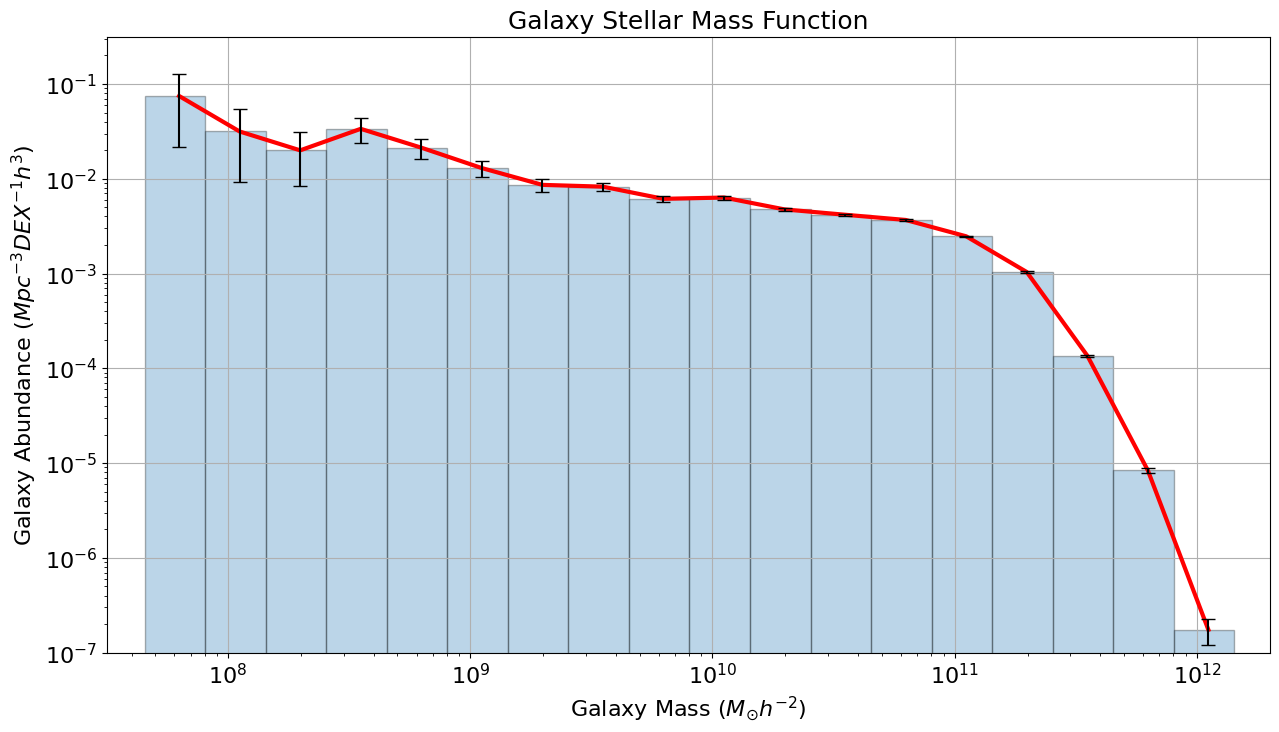

In [97]:
# plot the general mass function

bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', capsize=5, alpha=0.3)

plt.plot(bin_centers[10:] / 0.7, stellar_mass_function[10:] * 0.7**3, color='red', linewidth=3, label="This Work z < 0.4")
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', yerr=stellar_mass_function_error * 0.7**3, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.5, 10**12.3)
plt.ylim(10**-7, 10**-0.5)
plt.grid()

plt.title("Galaxy Stellar Mass Function")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
plt.savefig("../plots/mass_function_alone.pdf")

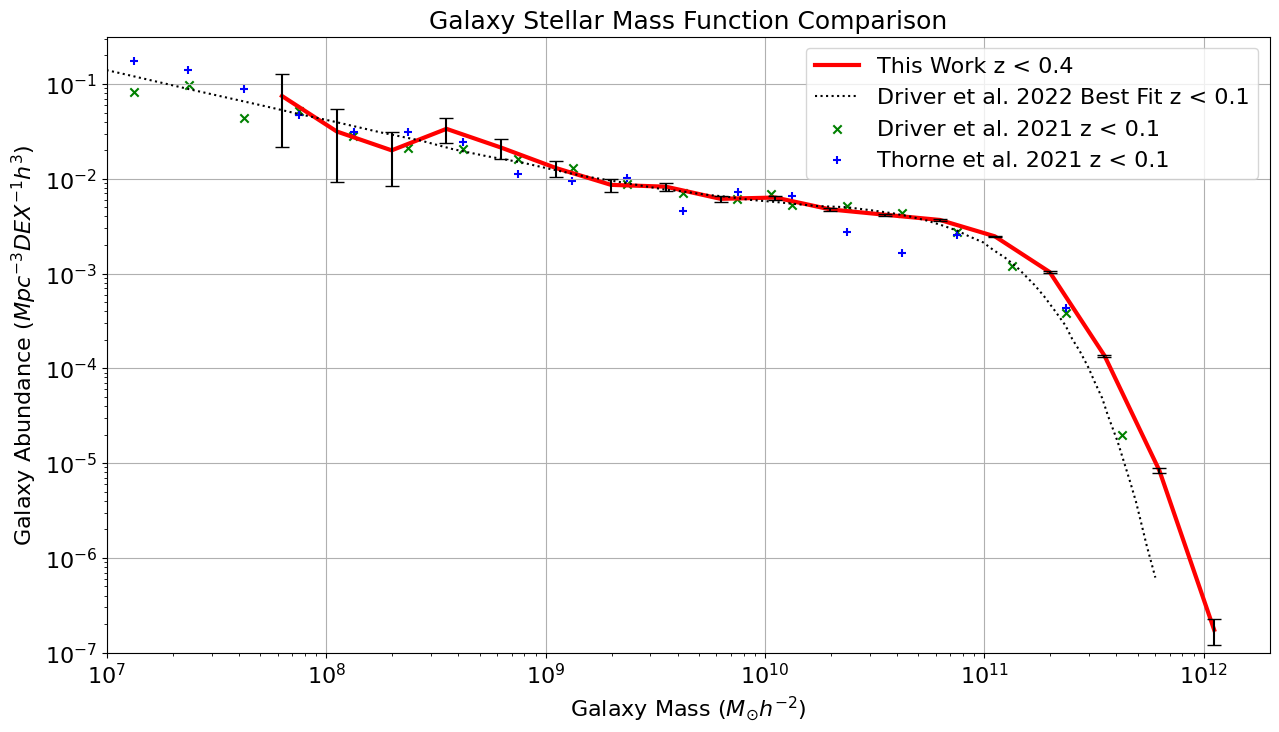

In [96]:
# plot the genral mass function in comparison to literature

driver_data = [
    [10592089241.071606, 2369869.6944553894, 7538693.833387387, 13309857.38108177, 23738825.124241762, 41911819.710567504, 74751917.33925602, 131977419.52876902, 235388614.08051398, 419827875.37884176, 748784921.6225241, 1335496978.0015333, 2357871894.3781643, 4205387553.2555575, 7424775405.802298, 13242474348.044937, 23618643968.891747, 42125083898.05727, 75132285145.39636, 134002350828.06511, 236586365976.58743, 421964128382.0898],
    [0.006967318970914501, 1.5742738878950842, 0.20427676806073872, 0.0824248934033175, 0.09833332623922979, 0.04388698704426618, 0.05235740364945357, 0.02858935645772137, 0.02112601181059174, 0.020600066063695462, 0.016009566116629886, 0.01308543972055536, 0.00874190010463911, 0.007145203438308527, 0.006142160600910127, 0.005279924801735736, 0.005148477654100756, 0.004315553414680678, 0.0027412977169118118, 0.0011930051975690154, 0.0003836556566345657, 1.958712987230559e-05]
    ]

driver_fit = [
    [999999.9999999979, 1783552.1782512385, 3246300.246917085, 5559559.870298519, 11546598.849829603, 24472863.65275783, 50827465.824160166, 73996948.97525889, 105563097.10061432, 177152303.50473756, 271334349.03979236, 375471965.88607514, 541108492.0808848, 779814278.5735711, 1036167177.2939708, 1478182788.1271865, 2066376265.420864, 2859447620.1909504, 3467720494.955915, 4248293843.3799896, 5365504710.173997, 6708077780.659355, 8558598339.046848, 11143567469.473818, 13791237352.740849, 17418039265.4727, 23380103880.13257, 30441639473.009586, 38447142782.36005, 45688717140.6936, 54848200135.01474, 65178937114.53102, 75898836999.02145, 84865050858.93001, 98822701737.7923, 109381016349.15334, 124810969107.63235, 140979197166.35397, 169242117200.23944, 187324111392.56787, 211590399648.69608, 234196925972.59842, 251443754194.162, 272715007285.74036, 298803545095.7369, 317568110213.2125, 344433250163.92816, 366063315326.8231, 405173879832.06757, 430618396059.521, 462330176541.0152, 491364051292.0603, 516946971747.10596, 549410726855.9097, 601968606466.0315],
    [0.45770319244178953, 0.34685342348978637, 0.2563062072427436, 0.1893966367989292, 0.12975935739737846, 0.086687445300608, 0.05939127212997525, 0.048543533642465, 0.04069012753790352, 0.030835507096780453, 0.025203441893940325, 0.020600066063695462, 0.01726737327353827, 0.014843381398114882, 0.012759669223549224, 0.010695401201561898, 0.00942871600186517, 0.008312047745422194, 0.007706573306598428, 0.007327629521189408, 0.006793863052548253, 0.006459798601298719, 0.005989247534602785, 0.005694747236971051, 0.005414727961338179, 0.005148477654100756, 0.005020302968341689, 0.004654609072495616, 0.004315553414680678, 0.00400119558590053, 0.0036173802289164183, 0.0031889641357478065, 0.0028112865155267446, 0.0024783382741083064, 0.0021304294320497598, 0.0017857671000855104, 0.0014595990655141447, 0.0011633045604912686, 0.0007578129871442826, 0.0005742805234845395, 0.0003934508708953232, 0.00028350109752376556, 0.00020427676806073882, 0.0001509496522267865, 0.00010084390045553473, 0.00007266309105547157, 0.000048543533642464994, 0.000031622776601683856, 0.00001683749083218063, 0.000010695401201561919, 0.000006298977731244287, 0.000003901583230299675, 0.000002416638437607031, 0.000001353277500459781, 6.193994322200882e-7]
]


thorne_data = [
    [1315316.0661431996, 2345934.8348585586, 4184097.18474745, 7387186.431545402, 13309857.38108177, 23499071.24761648, 41911819.710567504, 74751917.33925602, 133323944.99888687, 235388614.08051398, 419827875.37884176, 748784921.6225241, 1322008923.052673, 2357871894.3781643, 4205387553.2555575, 7500528130.999611, 13242474348.044937, 23618643968.891747, 42125083898.05727, 75132285145.39636, 236586365976.58743],
    [0.12337889488464229, 0.13307227794492088, 0.13995402771019344, 0.17122873268028785, 0.17560041883999153, 0.13995402771019344, 0.08890068544382826, 0.04733501093181445, 0.030835507096780453, 0.030835507096780453, 0.024575985884253748, 0.011248507196627282, 0.00942871600186517, 0.010169492259085767, 0.0045387295649438626, 0.007327629521189408, 0.006624725431613469, 0.0027412977169118118, 0.001655686479050854, 0.002541613385489369, 0.0004351972389605999]
]


bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
#plt.bar(bin_centers * 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', yerr=stellar_mass_function_error * 0.7**3, capsize=5, alpha=0.0)

plt.plot(bin_centers[10:] / 0.7, stellar_mass_function[10:] * 0.7**3, color='red', linewidth=3, label="This Work z < 0.4")
plt.bar(bin_centers / 0.7, stellar_mass_function * 0.7**3, width=np.diff(MASS_BINS) / 0.7, edgecolor='black', yerr=stellar_mass_function_error * 0.7**3, capsize=5, alpha=0.0)

plt.plot(driver_fit[0], driver_fit[1], label="Driver et al. 2022 Best Fit z < 0.1", color="black", linestyle="dotted")

plt.scatter(driver_data[0], driver_data[1], label="Driver et al. 2021 z < 0.1", color="green", marker="x")
plt.scatter(thorne_data[0], thorne_data[1], label="Thorne et al. 2021 z < 0.1", color="blue", marker="+")


plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7, 10**12.3)
plt.ylim(10**-7, 10**-0.5)
plt.grid()

plt.legend()

plt.title("Galaxy Stellar Mass Function Comparison")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
plt.savefig("../plots/mass_function_compared_to_others.pdf")

In [37]:
# cluster volume

cluster_df['distance'] = get_comoving_distance_from_redshift(cluster_df["z"])
cluster_df['cluster_volume'] = get_sphere_volume(cluster_df['cluster_radius_Mpc'])

cluster_volumes_by_mass_bin = [get_cluster_volume_sum_from_mass(mass=mass, cluster_dataframe=cluster_df, z_max=0.4) for mass in MASS_BINS]

In [38]:
# find the mass function for field galaxies
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[(merged_galaxy_df['within_richards_curve']) & (merged_galaxy_df["environment"] == "Field")], region_name='G09')
stellar_mass_function_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

In [39]:
# and cluster galaxies
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[(merged_galaxy_df["within_richards_curve"] == True) & (merged_galaxy_df["environment"] == "ClusterMember")], region_name='G09')
stellar_mass_function_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

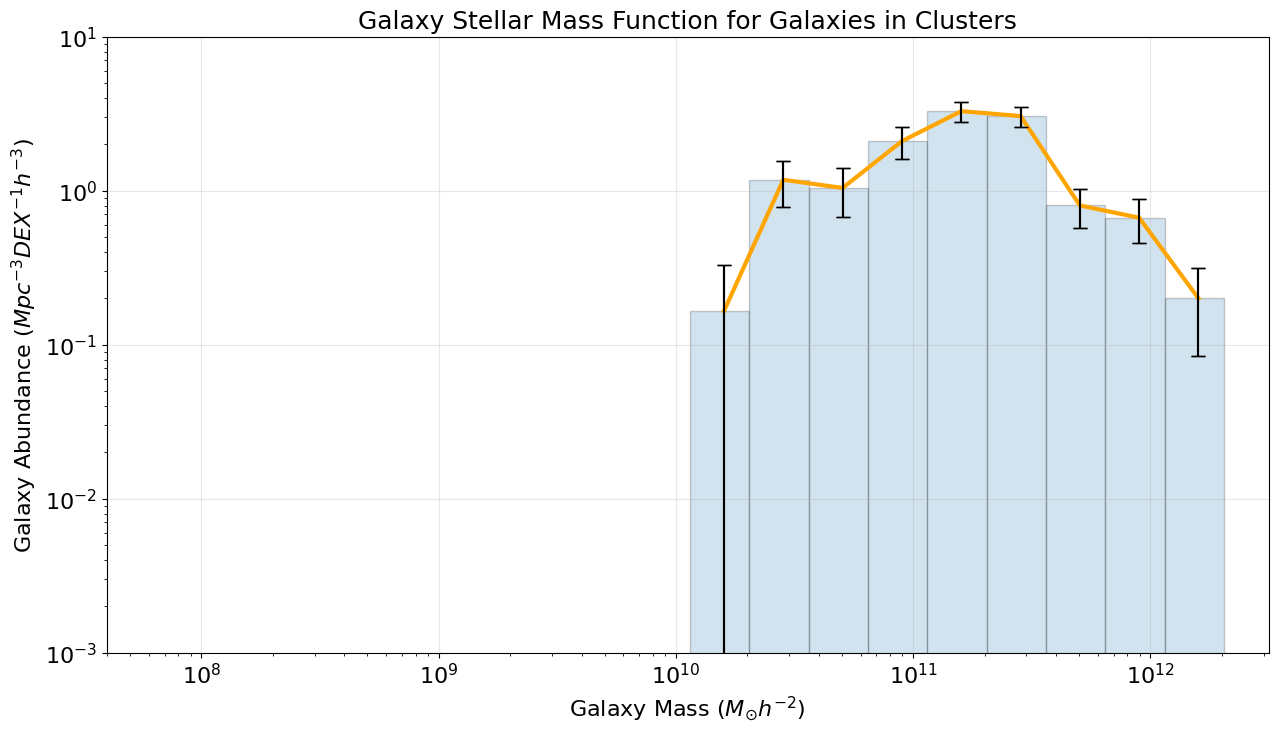

In [40]:
# plot the cluster function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster, capsize=5, alpha=0.2)

plt.plot(bin_centers[19:] / 0.7**2, stellar_mass_function_cluster[12:], color='orange', linewidth=3)
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_cluster, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster, capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.ylim(10**-3, 10**1)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Galaxies in Clusters")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-3}$)')
plt.savefig("../plots/mass_function_cluster_galaxies.pdf")

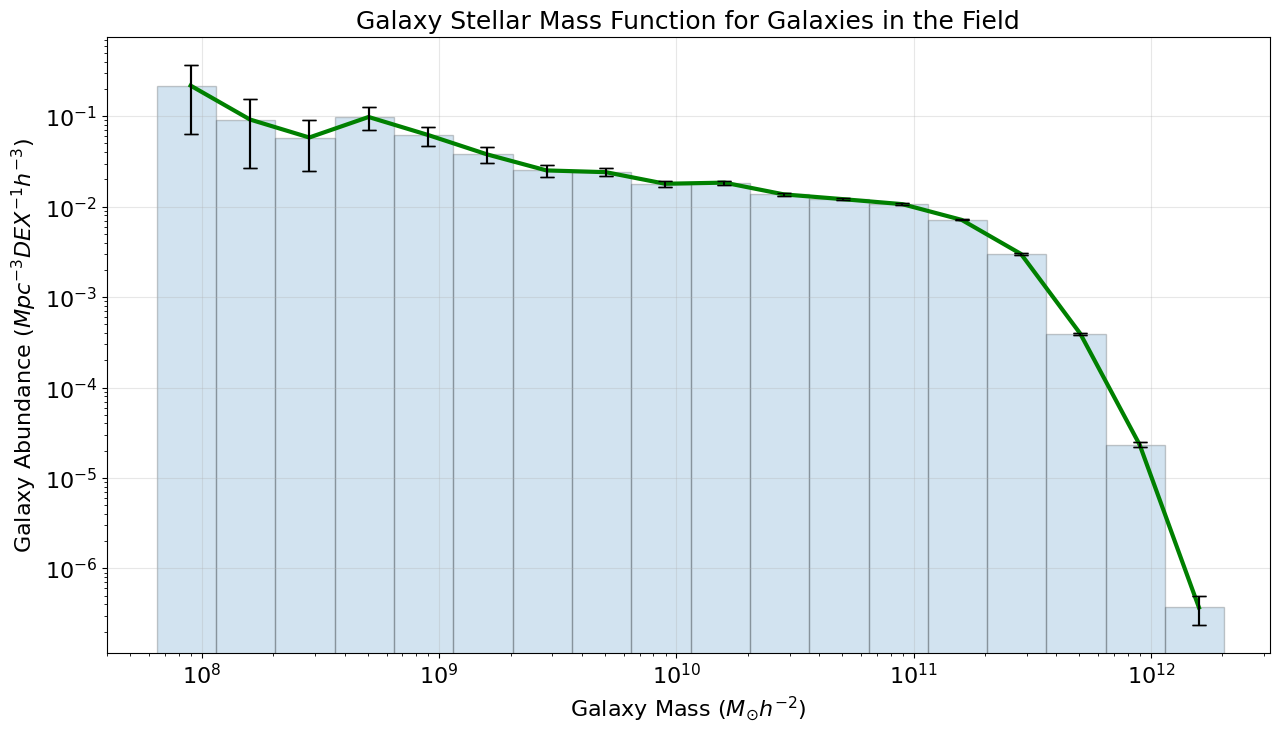

In [41]:
# plot the field function
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:], width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:], capsize=5, alpha=0.2)

plt.plot(bin_centers[10:] / 0.7**2, stellar_mass_function_field[10:], color='green', linewidth=3)
plt.bar(bin_centers[7:] / 0.7**2, stellar_mass_function_field[7:], width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:], capsize=5, alpha=0.0)

plt.xscale('log'); plt.yscale('log')
plt.xlim(10**7.6, 10**12.5)
plt.grid(alpha=0.3)

plt.title("Galaxy Stellar Mass Function for Galaxies in the Field")
plt.xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
plt.ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{-3}$)')
plt.savefig("../plots/mass_function_field_galaxies.pdf")

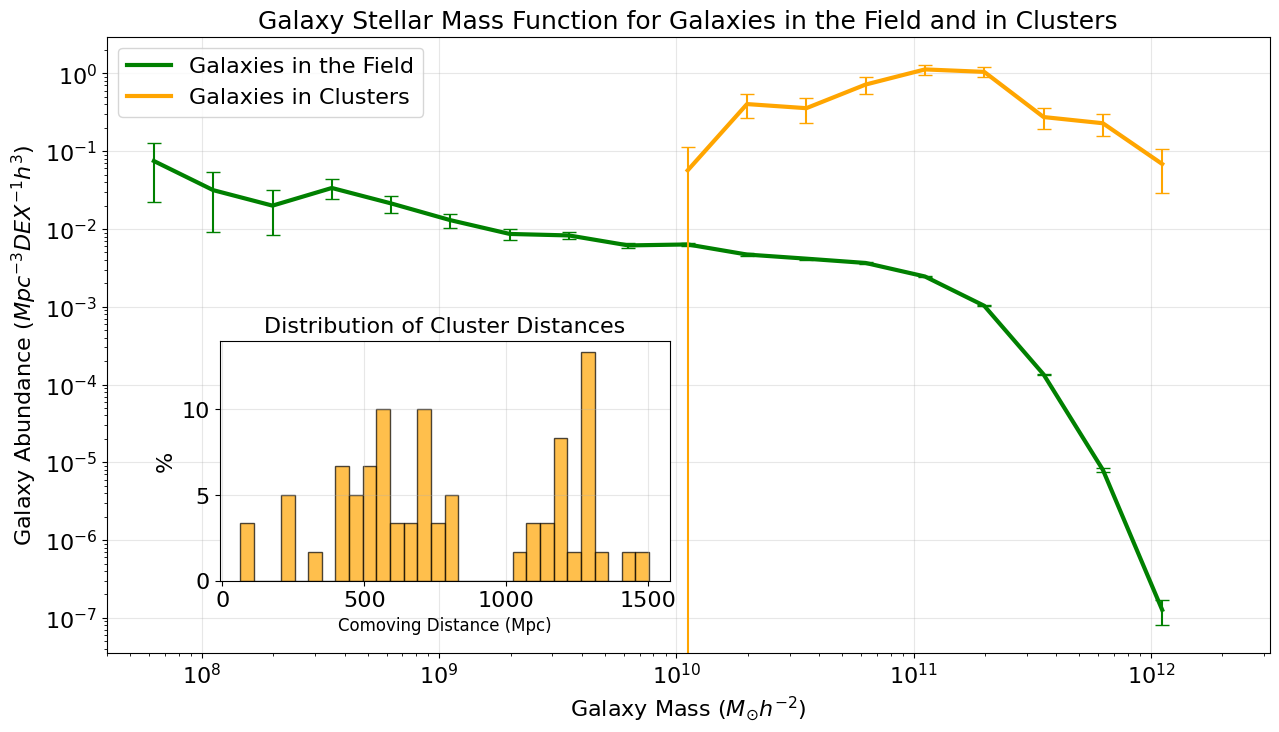

In [291]:
# plot field and cluster together
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

ax.plot(bin_centers[10:] / 0.7, stellar_mass_function_field[10:] * 0.7**3, color='green', linewidth=3, label="Galaxies in the Field")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_field[7:] * 0.7**3, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_field[7:] * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.plot(bin_centers[19:] / 0.7, stellar_mass_function_cluster[12:] * 0.7**3, color='orange', linewidth=3, label="Galaxies in Clusters")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_cluster * 0.7**3, width=np.diff(MASS_BINS[7:]) / 0.7**2, edgecolor='black', yerr=stellar_mass_function_error_cluster * 0.7**3, capsize=5, alpha=0.0, ecolor="orange")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Galaxies in the Field and in Clusters")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
ax.legend()

inset_axes = fig.add_axes([0.2, 0.2, 0.3, 0.3])
n, bins, patches = inset_axes.hist(cosmo.comoving_distance(cluster_df["z"]).value, bins=30, color='orange', alpha=0.7, density=True)
n_percentage = n/n.sum() * 100
inset_axes.clear()
inset_axes.bar(bins[:-1], n_percentage, width=np.diff(bins), edgecolor='black', color='orange', alpha=0.7)
inset_axes.set_ylim(0, 14)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"Comoving Distance (Mpc)", fontsize=12)
inset_axes.set_title(r"Distribution of Cluster Distances", fontsize=16)
inset_axes.grid(alpha=0.3)

plt.savefig("../plots/mass_function_cluster_vs_field.pdf")

In [27]:
# find the mass functions for galaxies by age group
median_age = merged_galaxy_df["log_age"].median()
print(f"median age: {median_age}")

# young
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_age"] < median_age)
        ],
    region_name='G09'
    )
stellar_mass_function_young = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_young = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# old
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_age"] > median_age)
        ],
    region_name='G09'
    )
stellar_mass_function_old = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_old = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

median age: median_age


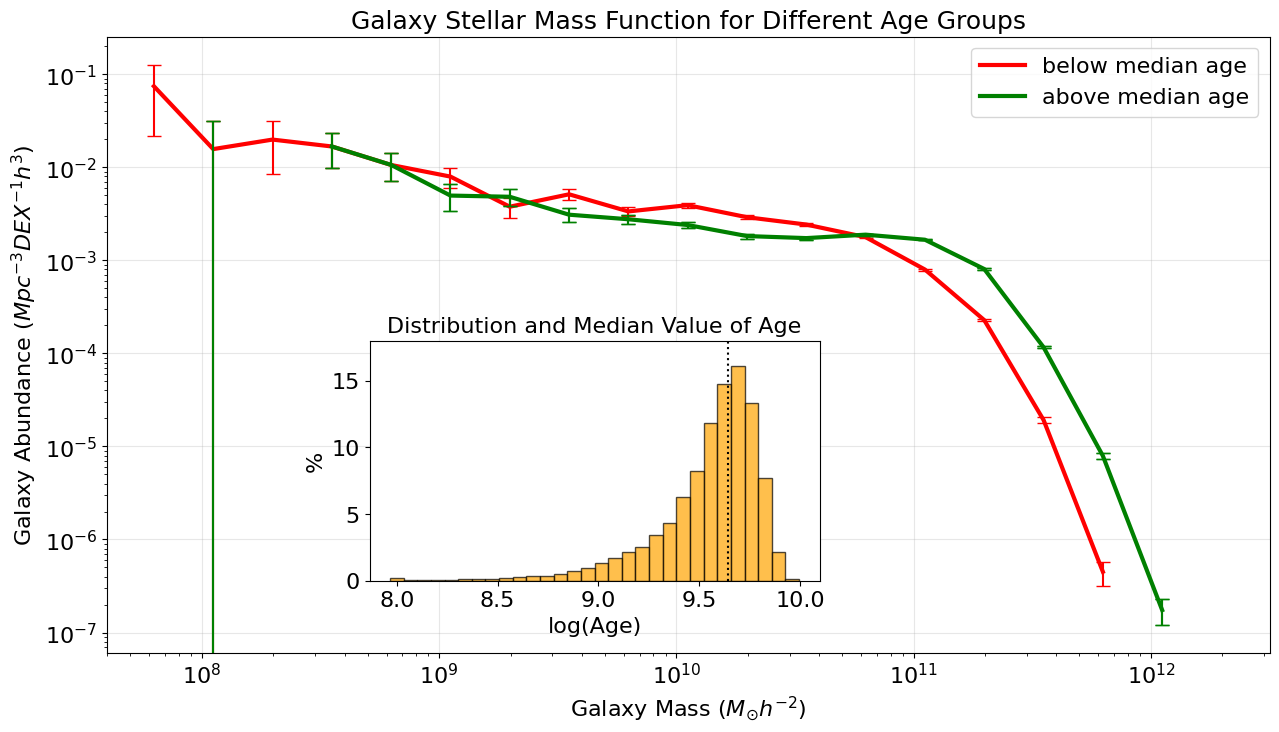

In [243]:
# plot the different age groups
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

ax.plot(bin_centers[10:-1] / 0.7, stellar_mass_function_young[10:-1] * 0.7**3, color='red', linewidth=3, label="below median age")
ax.bar(bin_centers / 0.7, stellar_mass_function_young * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_young * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

ax.plot(bin_centers[11] / 0.7, stellar_mass_function_old[11] * 0.7**3, color='green', linewidth=3, label="above median age")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_old[7:] * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_old[7:] * 0.7**3, capsize=5, alpha=0.0, ecolor="green")
ax.plot(bin_centers[13:] / 0.7, stellar_mass_function_old[13:] * 0.7**3, color='green', linewidth=3)
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_old[7:] * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_old[7:] * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Age Groups")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
plt.legend()

inset_axes = fig.add_axes([0.3, 0.2, 0.3, 0.3])
n, bins, patches = inset_axes.hist(merged_galaxy_df["log_age"], bins=30, color='orange', alpha=0.7, density=True)
n_percentage = n/n.sum() * 100
inset_axes.clear()
inset_axes.bar(bins[:-1], n_percentage, width=np.diff(bins), edgecolor='black', color='orange', alpha=0.7)
inset_axes.vlines(median_age, ymin=0, ymax=18, linestyles="dotted", colors="black")
inset_axes.set_ylim(0, 18)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"log(Age)")
inset_axes.set_title(r"Distribution and Median Value of Age", fontsize=16)

plt.savefig("../plots/mass_function_by_age_group.pdf")

In [99]:
# find the mass functions for galaxies by star formation (tau?)
median_tau = merged_galaxy_df["log_tau"].median()
print(f"median tau: {median_tau}")

# low tau
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] < median_tau)
        ],
    region_name='G09'
    )
stellar_mass_function_low_tau = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_low_tau = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# high tau
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] > median_tau)
        ],
    region_name='G09'
    )
stellar_mass_function_high_low = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_high_tau = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

median tau: 8.451172828674316


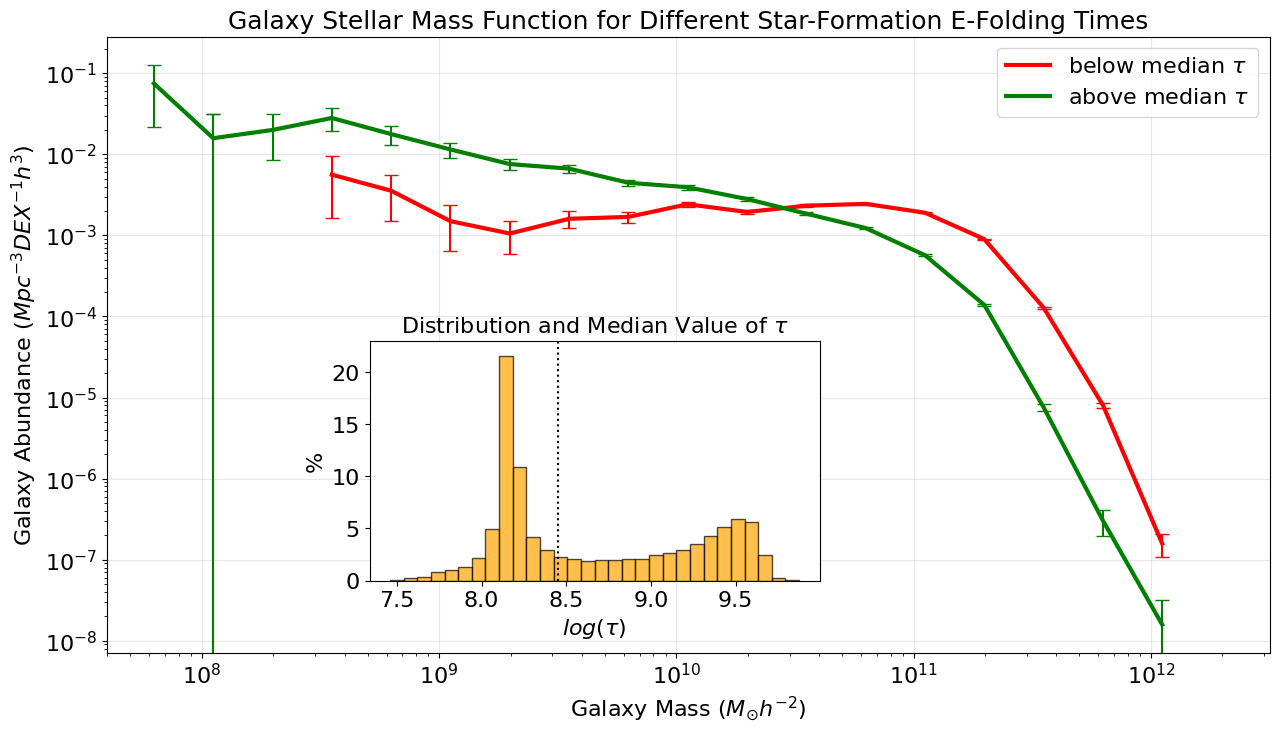

In [293]:
# plot the different star formation rates
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

ax.plot(bin_centers[13:] / 0.7, stellar_mass_function_low_tau[13:] * 0.7**3, color='red', linewidth=3, label=r"below median $\tau$")
ax.bar(bin_centers / 0.7, stellar_mass_function_low_tau * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_low_tau * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

ax.plot(bin_centers[10:] / 0.7, stellar_mass_function_high_low[10:] * 0.7**3, color='green', linewidth=3, label=r"above median $\tau$")
ax.bar(bin_centers / 0.7, stellar_mass_function_high_low * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_high_tau * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Star-Formation E-Folding Times")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
ax.legend()

inset_axes = fig.add_axes([0.3, 0.2, 0.3, 0.3])
n, bins, patches = inset_axes.hist(merged_galaxy_df["log_tau"], bins=30, color='orange', alpha=0.7, density=True)
n_percentage = n/n.sum() * 100
inset_axes.clear()
inset_axes.bar(bins[:-1], n_percentage, width=np.diff(bins), edgecolor='black', color='orange', alpha=0.7)
inset_axes.vlines(median_tau, ymin=0, ymax=23, linestyles="dotted", colors="black")
inset_axes.set_ylim(0, 23)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"$log(\tau)$")
inset_axes.set_title(r"Distribution and Median Value of $\tau$", fontsize=16)

plt.savefig("../plots/mass_function_by_efolding_time.pdf")

In [115]:
# find the mass functions for galaxies by metallicity
median_met = merged_galaxy_df["log_met"].median()
print(f"median met: {median_met}")

# young
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] < median_met)
        ],
    region_name='G09'
    )
stellar_mass_function_low_met = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_low_met = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# old
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] > median_met)
        ],
    region_name='G09'
    )
stellar_mass_function_high_met = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_high_met = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

median met: -2.4311885833740234


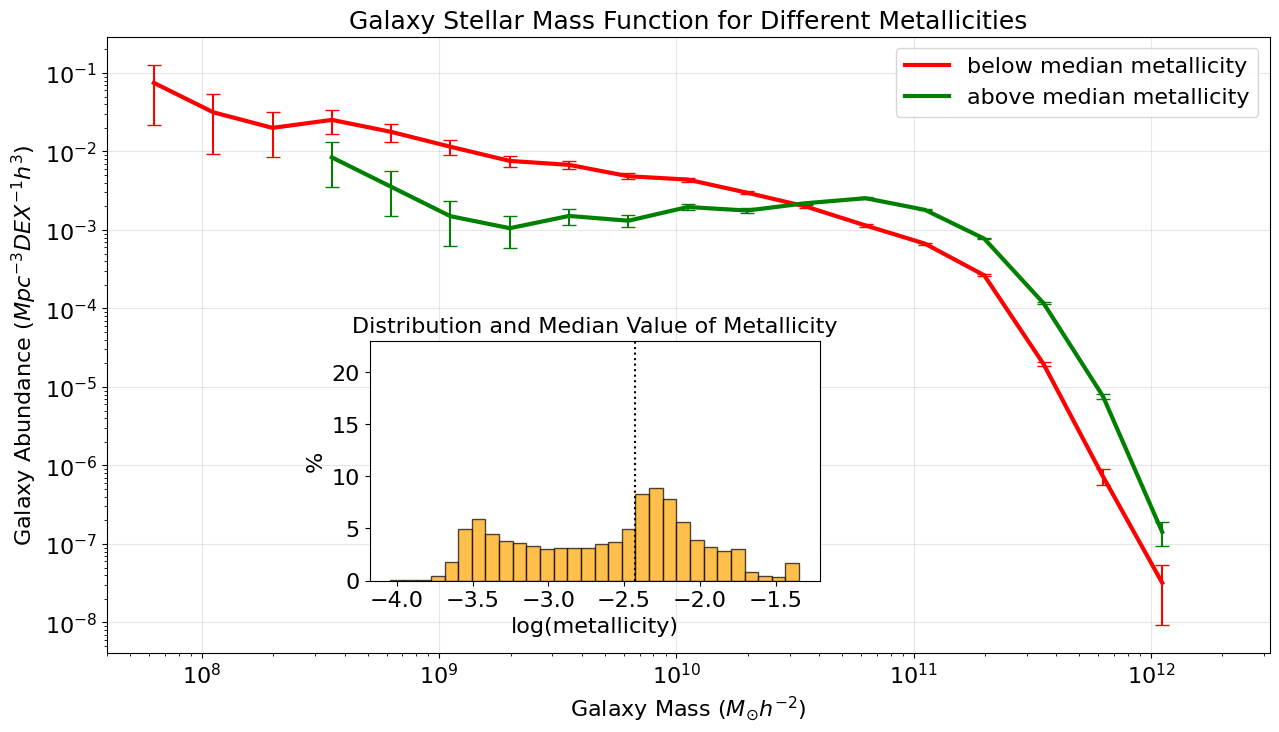

In [300]:
# plot the different metallicities
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

ax.plot(bin_centers[10:] / 0.7, stellar_mass_function_low_met[10:] * 0.7**3, color='red', linewidth=3, label="below median metallicity")
ax.bar(bin_centers / 0.7, stellar_mass_function_low_met * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_low_met * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

ax.plot(bin_centers[13:] / 0.7, stellar_mass_function_high_met[13:] * 0.7**3, color='green', linewidth=3, label="above median metallicity")
ax.bar(bin_centers / 0.7, stellar_mass_function_high_met * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_high_met * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Metallicities")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
plt.legend()

inset_axes = fig.add_axes([0.3, 0.2, 0.3, 0.3])
n, bins, patches = inset_axes.hist(merged_galaxy_df["log_met"], bins=30, color='orange', alpha=0.7, density=True)
n_percentage = n/n.sum() * 100
inset_axes.clear()
inset_axes.bar(bins[:-1], n_percentage, width=np.diff(bins), edgecolor='black', color='orange', alpha=0.7)
inset_axes.vlines(median_met, ymin=0, ymax=23, linestyles="dotted", colors="black")
inset_axes.set_ylim(0, 23)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"log(metallicity)")
inset_axes.set_title(r"Distribution and Median Value of Metallicity", fontsize=16)

plt.savefig("../plots/mass_function_by_metallicity.pdf")

In [313]:
# find the mass functions for galaxies by morphology
morph_mass_functions = {}

for morph in ['D', 'E', 'cBD', 'dBD']:
    print(f"found { len( merged_galaxy_df[(merged_galaxy_df['morphology'] == morph)] ) } galaxies for morphology {morph}")
    
    mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["morphology"] == morph)
        ],
    region_name='G09'
    )
    morph_mass_functions[morph] = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff), mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

found 1539 galaxies for morphology D
found 235 galaxies for morphology E
found 601 galaxies for morphology cBD
found 1187 galaxies for morphology dBD


In [26]:
for morph in ['D', 'E', 'cBD', 'dBD']:
    print(f"found { len( merged_galaxy_df[(merged_galaxy_df['morphology'] == morph) & (merged_galaxy_df['environment'] != 'Field') & (merged_galaxy_df['within_richards_curve'])] )} galaxies for morphology {morph} in clusters")

found 0 galaxies for morphology D in clusters
found 2 galaxies for morphology E in clusters
found 3 galaxies for morphology cBD in clusters
found 1 galaxies for morphology dBD in clusters


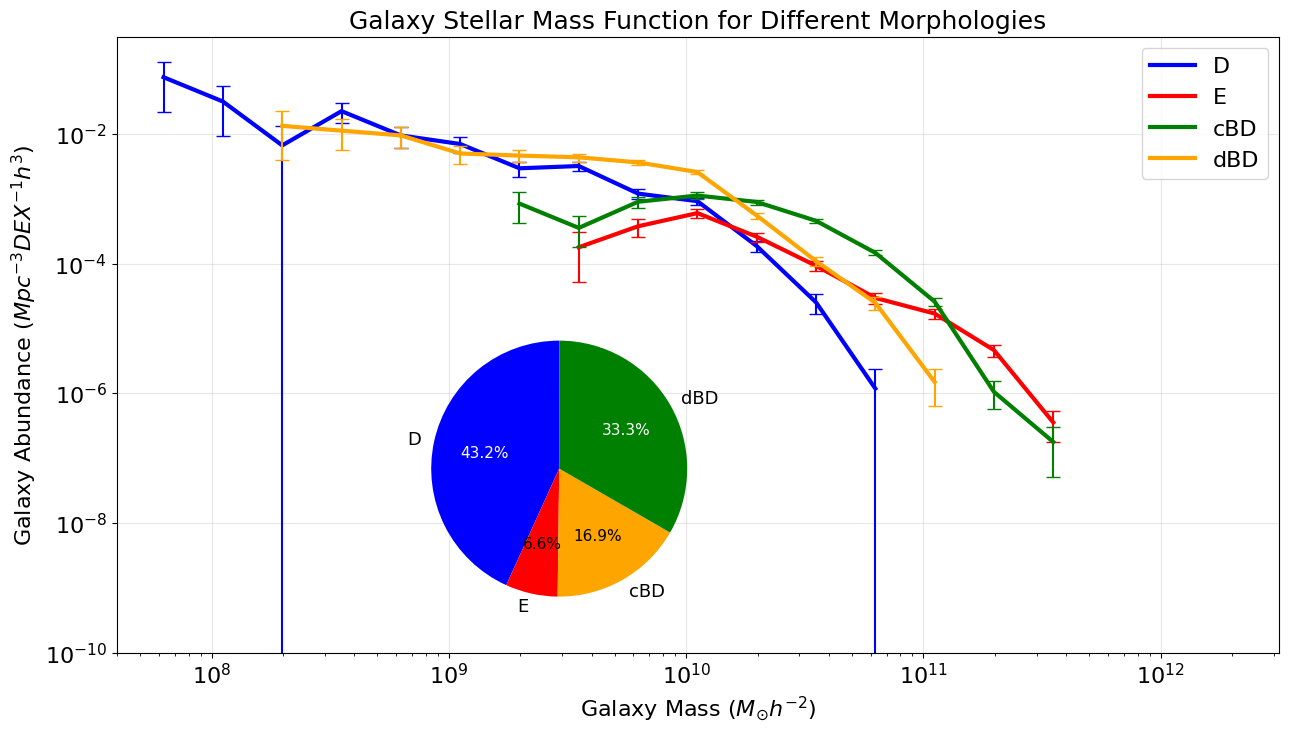

In [315]:
# plot the different metallicities
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

morph = "D"
col = "blue"
start = 10
end = 23
ax.plot(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, linewidth=3, label=morph, color=col)
ax.bar(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, width=np.diff(MASS_BINS)[start:end], edgecolor='black', yerr=morph_mass_functions[morph][1][start:end] * 0.7**3, capsize=5, alpha=0.0, ecolor=col)

morph = "E"
col = "red"
start = 17
end = 26
ax.plot(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, linewidth=3, label=morph, color=col)
ax.bar(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, width=np.diff(MASS_BINS)[start:end], edgecolor='black', yerr=morph_mass_functions[morph][1][start:end] * 0.7**3, capsize=5, alpha=0.0, ecolor=col)

morph = "cBD"
col = "green"
start = 16
end = 26
ax.plot(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, linewidth=3, label=morph, color=col)
ax.bar(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, width=np.diff(MASS_BINS)[start:end], edgecolor='black', yerr=morph_mass_functions[morph][1][start:end] * 0.7**3, capsize=5, alpha=0.0, ecolor=col)

morph = "dBD"
col = "orange"
start = 12
end = 24
ax.plot(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, linewidth=3, label=morph, color=col)
ax.bar(bin_centers[start:end] / 0.7, morph_mass_functions[morph][0][start:end] * 0.7**3, width=np.diff(MASS_BINS)[start:end], edgecolor='black', yerr=morph_mass_functions[morph][1][start:end] * 0.7**3, capsize=5, alpha=0.0, ecolor=col)


ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.set_ylim(10**-10, 10**-.5)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Morphologies")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
ax.legend()

inset_axes = fig.add_axes([0.22, 0.14, 0.4, 0.4])
morphology_counts = [1539, 235, 601, 1187]
morphology_labels = ['D', 'E', 'cBD', 'dBD']
morphology_colors = ["blue", "red", "orange", "green"]
wedges, texts, autotexts = inset_axes.pie(morphology_counts, labels=morphology_labels, autopct='%1.1f%%', startangle=90, colors=morphology_colors)
text_colors = ["white", "black", "black", "white"]
for i, autotext in enumerate(autotexts):
    autotext.set_color(text_colors[i])  # Change text color to white
    autotext.set_fontsize(11)
for text in texts:
    text.set_fontsize(13) 

plt.savefig("../plots/mass_function_by_morphology.pdf")

In [301]:
for morph in pd.unique(merged_galaxy_df['morphology']):
    print(f"found {len(merged_galaxy_df[(merged_galaxy_df['morphology'] == morph)])} galaxies for morphology {morph}")

found 235 galaxies for morphology E
found 1187 galaxies for morphology dBD
found 1539 galaxies for morphology D
found 601 galaxies for morphology cBD
found 10 galaxies for morphology HE
found 28 galaxies for morphology H
found 33 galaxies for morphology C
found 41887 galaxies for morphology 


In [339]:
# find the mass functions for galaxies by star formation and environment
median_tau = merged_galaxy_df["log_tau"].median()
print(f"median tau: {median_tau}")

# low tau field
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] < median_tau) &
        (merged_galaxy_df["environment"] == "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_low_tau_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_low_tau_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# low tau cluster
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] < median_tau) &
        (merged_galaxy_df["environment"] != "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_low_tau_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_low_tau_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

# high tau field
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] > median_tau) &
        (merged_galaxy_df["environment"] == "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_high_tau_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_high_tau_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# high tau cluster
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_tau"] > median_tau) &
        (merged_galaxy_df["environment"] != "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_high_tau_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_high_tau_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

median tau: 8.451172828674316


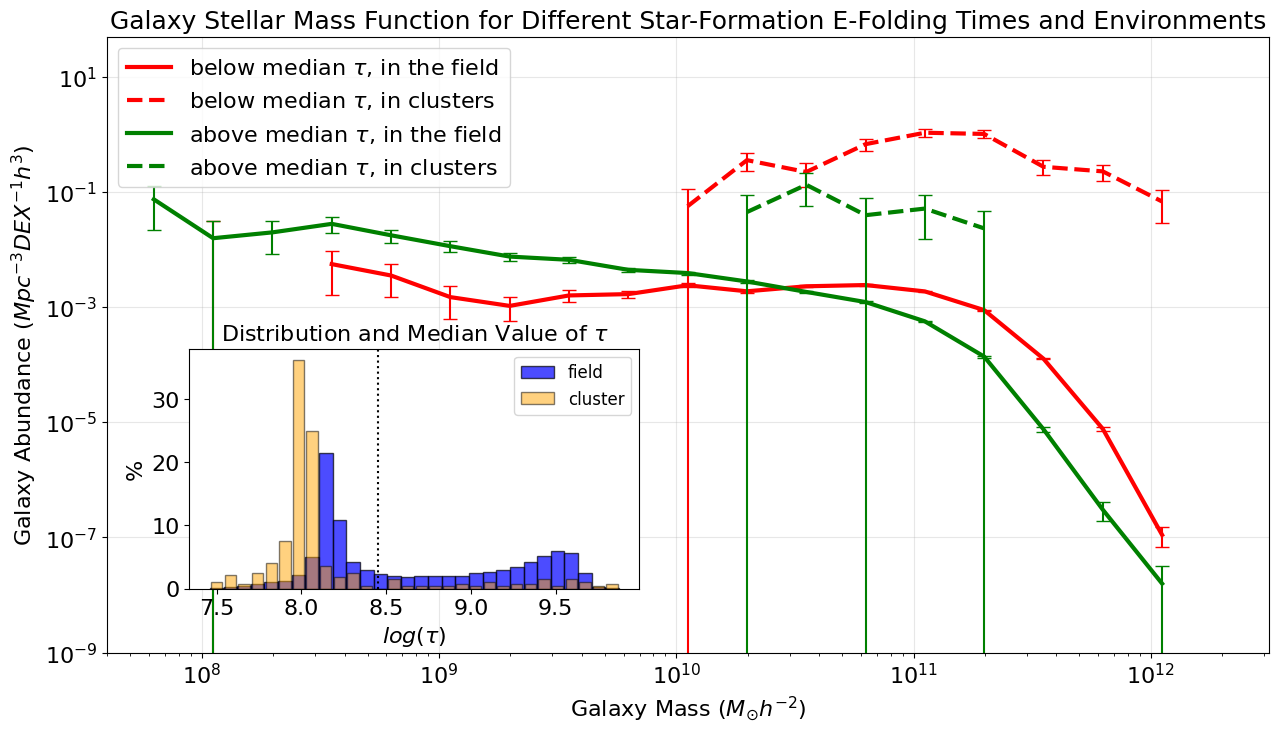

In [377]:
# plot the different star formation rates and environment
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

# low tau field
ax.plot(bin_centers[13:] / 0.7, stellar_mass_function_low_tau_field[13:] * 0.7**3, color='red', linewidth=3, label=r"below median $\tau$, in the field")
ax.bar(bin_centers / 0.7, stellar_mass_function_low_tau_field * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_low_tau_field * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

# low tau cluster
ax.plot(bin_centers[19:] / 0.7, stellar_mass_function_low_tau_cluster[12:] * 0.7**3, color='red', linewidth=3, label=r"below median $\tau$, in clusters", linestyle="dashed")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_low_tau_cluster * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_low_tau_cluster * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

# high tau field
ax.plot(bin_centers[10:] / 0.7, stellar_mass_function_high_tau_field[10:] * 0.7**3, color='green', linewidth=3, label=r"above median $\tau$, in the field")
ax.bar(bin_centers / 0.7, stellar_mass_function_high_tau_field * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_high_tau_field * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

# high tau cluster
ax.plot(bin_centers[20:25] / 0.7, stellar_mass_function_high_tau_cluster[13:18] * 0.7**3, color='green', linewidth=3, label=r"above median $\tau$, in clusters", linestyle="dashed")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_high_tau_cluster * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_high_tau_cluster * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.set_ylim(10**-9, 10**1.7)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Star-Formation E-Folding Times and Environments")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
ax.legend()

inset_axes = fig.add_axes([0.18, 0.19, 0.3, 0.3])

n_field, bins_field, patches_field = inset_axes.hist(merged_galaxy_df[merged_galaxy_df["environment"] == "Field"]["log_tau"], bins=30, color='blue', alpha=0.7, density=True)
n_percentage_field = n_field/n_field.sum() * 100
n_cluster, bins_cluster, patches_cluster = inset_axes.hist(merged_galaxy_df[merged_galaxy_df["environment"] != "Field"]["log_tau"], bins=30, color='orange', alpha=0.7, density=True)
n_percentage_cluster = n_cluster/n_cluster.sum() * 100
inset_axes.clear()

inset_axes.bar(bins_field[:-1], n_percentage_field, width=np.diff(bins_field), edgecolor='black', color='blue', alpha=0.7, label="field")
inset_axes.bar(bins_field[:-1], n_percentage_cluster, width=np.diff(bins_cluster), edgecolor='black', color='orange', alpha=0.5, label="cluster")

inset_axes.vlines(median_tau, ymin=0, ymax=38, linestyles="dotted", colors="black")
inset_axes.set_ylim(0, 38)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"$log(\tau)$")
inset_axes.legend(fontsize=12)
inset_axes.set_title(r"Distribution and Median Value of $\tau$", fontsize=16)

plt.savefig("../plots/mass_function_by_efolding_time_and_environment.pdf")

In [360]:
# find the mass functions for galaxies by metallicity and environment
median_met = merged_galaxy_df["log_met"].median()
print(f"median met: {median_met}")

# low met field
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] < median_met) &
        (merged_galaxy_df["environment"] == "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_low_met_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_low_met_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# low met cluster
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] < median_met) &
        (merged_galaxy_df["environment"] != "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_low_met_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_low_met_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

# high met field
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] > median_met) &
        (merged_galaxy_df["environment"] == "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_high_met_field = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)
stellar_mass_function_error_high_met_field = mass_histogram_error / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

# high met cluster
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(
    merged_galaxy_df[
        (merged_galaxy_df['within_richards_curve']) & 
        (merged_galaxy_df["log_met"] > median_met) &
        (merged_galaxy_df["environment"] != "Field")
        ],
    region_name='G09'
    )
stellar_mass_function_high_met_cluster = mass_histogram[7:] / cluster_volumes_by_mass_bin[8:]
stellar_mass_function_error_high_met_cluster = mass_histogram_error[7:] / cluster_volumes_by_mass_bin[8:]

median met: -2.4311885833740234


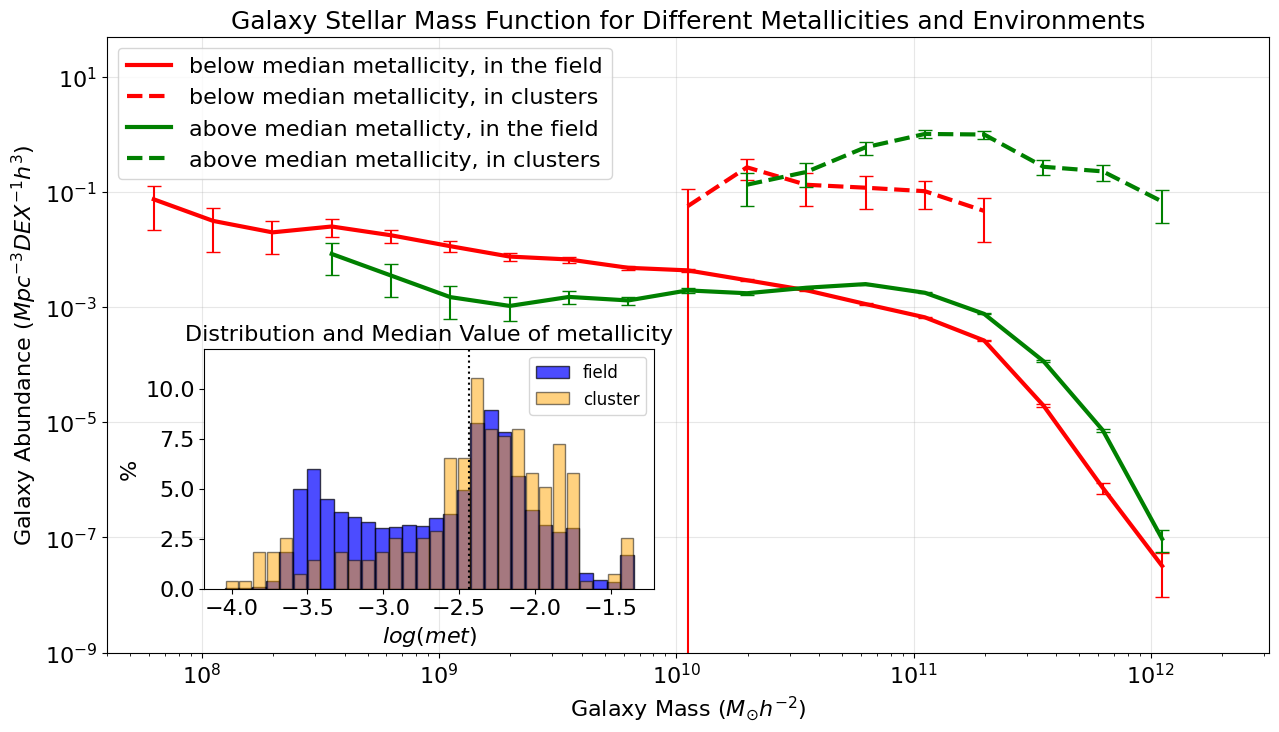

In [376]:
# plot the different star formation rates and environment
bin_centers = 0.5 * (MASS_BINS[:-1] + MASS_BINS[1:])

fig, ax = plt.subplots()

# low met field
ax.plot(bin_centers[10:] / 0.7, stellar_mass_function_low_met_field[10:] * 0.7**3, color='red', linewidth=3, label=r"below median metallicity, in the field")
ax.bar(bin_centers / 0.7, stellar_mass_function_low_met_field * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_low_met_field * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

# low met cluster
ax.plot(bin_centers[19:25] / 0.7, stellar_mass_function_low_met_cluster[12:18] * 0.7**3, color='red', linewidth=3, label=r"below median metallicity, in clusters", linestyle="dashed")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_low_met_cluster * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_low_met_cluster * 0.7**3, capsize=5, alpha=0.0, ecolor="red")

# high met field
ax.plot(bin_centers[13:] / 0.7, stellar_mass_function_high_met_field[13:] * 0.7**3, color='green', linewidth=3, label=r"above median metallicty, in the field")
ax.bar(bin_centers / 0.7, stellar_mass_function_high_met_field * 0.7**3, width=np.diff(MASS_BINS), edgecolor='black', yerr=stellar_mass_function_error_high_met_field * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

# high met cluster
ax.plot(bin_centers[20:29] / 0.7, stellar_mass_function_high_met_cluster[13:21] * 0.7**3, color='green', linewidth=3, label=r"above median metallicity, in clusters", linestyle="dashed")
ax.bar(bin_centers[7:] / 0.7, stellar_mass_function_high_met_cluster * 0.7**3, width=np.diff(MASS_BINS[7:]), edgecolor='black', yerr=stellar_mass_function_error_high_met_cluster * 0.7**3, capsize=5, alpha=0.0, ecolor="green")

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(10**7.6, 10**12.5)
ax.set_ylim(10**-9, 10**1.7)
ax.grid(alpha=0.3)

ax.set_title("Galaxy Stellar Mass Function for Different Metallicities and Environments")
ax.set_xlabel(r'Galaxy Mass ($M_{\odot}h^{-2}$)')
ax.set_ylabel(r'Galaxy Abundance ($Mpc^{-3} DEX^{-1} h^{3}$)')
ax.legend()

inset_axes = fig.add_axes([0.19, 0.19, 0.3, 0.3])

n_field, bins_field, patches_field = inset_axes.hist(merged_galaxy_df[merged_galaxy_df["environment"] == "Field"]["log_met"], bins=30, color='blue', alpha=0.7, density=True)
n_percentage_field = n_field/n_field.sum() * 100
n_cluster, bins_cluster, patches_cluster = inset_axes.hist(merged_galaxy_df[merged_galaxy_df["environment"] != "Field"]["log_met"], bins=30, color='orange', alpha=0.7, density=True)
n_percentage_cluster = n_cluster/n_cluster.sum() * 100
inset_axes.clear()

inset_axes.bar(bins_field[:-1], n_percentage_field, width=np.diff(bins_field), edgecolor='black', color='blue', alpha=0.7, label="field")
inset_axes.bar(bins_field[:-1], n_percentage_cluster, width=np.diff(bins_cluster), edgecolor='black', color='orange', alpha=0.5, label="cluster")

inset_axes.vlines(median_met, ymin=0, ymax=38, linestyles="dotted", colors="black")
inset_axes.set_ylim(0, 12)
inset_axes.set_ylabel('%')
inset_axes.set_xlabel(r"$log(met)$")
inset_axes.legend(fontsize=12)
inset_axes.set_title(r"Distribution and Median Value of metallicity", fontsize=16)

plt.savefig("../plots/mass_function_by_metallicity_and_environment.pdf")